In [1]:
import os
import time
import math
from datetime import datetime

import numpy as np
import pandas as pd
import scipy as sp
from tqdm import tqdm
from functools import partial

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
def variance_weighted_result(means, stddevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert np.size(means) == np.size(stddevs)
    assert means.shape == stddevs.shape
    variance = 1./np.sum(1./stddevs**2, axis=-1)
    mean = np.sum(means/(stddevs**2), axis=-1)
    mean *= variance
    return mean, np.sqrt(variance)

In [5]:
def compute_stats(values):
    mean = sum(values) / len(values)
    var_unb = sum((v - mean) ** 2 for v in values) / (len(values) - 1)
    return mean, math.sqrt(var_unb)


def compute_stats_np(values):
    mean = np.mean(values)
    var_unb = np.sum((values - mean) ** 2) / (len(values) - 1)
    return mean, math.sqrt(var_unb)


@tf.function(input_signature=[tf.TensorSpec(shape=None, dtype=tf.float64)], jit_compile=True)
def compute_stats_tf(values):
    print('compute_stats_tf :: tracing..')
    mean = tf.reduce_mean(values, axis=-1)
    sum_2 = tf.reduce_sum((values - mean) ** 2, axis=-1)
    return mean, sum_2

In [7]:
compute_stats_tf(tf.random.uniform(shape=(10000,), dtype=tf.float64))

(<tf.Tensor: shape=(), dtype=float64, numpy=0.5008677268703706>,
 <tf.Tensor: shape=(), dtype=float64, numpy=842.9940952691483>)

In [8]:
NRUNS = 10

### F1 - simple gauss

In [9]:
import scipy.stats as spt

target = 1
target_precision = 1e-3

norm_dist = spt.norm(loc=0.5, scale=0.01)

prefix = 'f1'

target_dict = {
    'f1_d2': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 2,
    'f1_d4': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 4,
    'f1_d6': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 6,
    'f1_d8': (norm_dist.cdf(1) - norm_dist.cdf(0)) ** 8,
}
target_dict

{'f1_d2': 1.0, 'f1_d4': 1.0, 'f1_d6': 1.0, 'f1_d8': 1.0}

In [10]:
sigma = 0.01
alpha = sigma * math.sqrt(2)

alpha_tf = tf.constant(alpha, dtype=tf.float64)
pi_tf = tf.constant(math.pi, dtype=tf.float64)

@tf.function(input_signature=[tf.TensorSpec(shape=(None,2), dtype=tf.float64)], jit_compile=True)
def f1_tf_d2(x):
    print('f1_tf_d2 :: tracing..')
    pre = 1.0 / (alpha * tf.sqrt(pi_tf)) ** 2
    exponent = -1 * tf.reduce_sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)

@tf.function(input_signature=[tf.TensorSpec(shape=(None,4), dtype=tf.float64)], jit_compile=True)
def f1_tf_d4(x):
    print('f1_tf_d4 :: tracing..')
    pre = 1.0 / (alpha * tf.sqrt(pi_tf)) ** 4
    exponent = -1 * tf.reduce_sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)

@tf.function(input_signature=[tf.TensorSpec(shape=(None,6), dtype=tf.float64)], jit_compile=True)
def f1_tf_d6(x):
    print('f1_tf_d6 :: tracing..')
    pre = 1.0 / (alpha * tf.sqrt(pi_tf)) ** 6
    exponent = -1 * tf.reduce_sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)

@tf.function(input_signature=[tf.TensorSpec(shape=(None,8), dtype=tf.float64)], jit_compile=True)
def f1_tf_d8(x):
    print('f1_tf_d8 :: tracing..')
    pre = 1.0 / (alpha * tf.sqrt(pi_tf)) ** 8
    exponent = -1 * tf.reduce_sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)


def f1_np(x, ndims):
    pre = 1.0 / (alpha * math.sqrt(math.pi)) ** ndims
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)

def f1(x, ndims):
    pre = 1.0 / (alpha * math.sqrt(math.pi)) ** ndims
    exponent = -1 * sum((t - .5) ** 2 for t in x) / alpha ** 2
    return pre * math.exp(exponent)

In [13]:
f1_tf_d2(tf.random.uniform((10000000,2), dtype=tf.float64))
f1_tf_d4(tf.random.uniform((10000000,4), dtype=tf.float64))
f1_tf_d6(tf.random.uniform((10000000,6), dtype=tf.float64))
f1_tf_d8(tf.random.uniform((10000000,8), dtype=tf.float64))

f1_tf_d2 :: tracing..
f1_tf_d4 :: tracing..
f1_tf_d6 :: tracing..


<tf.Tensor: shape=(10000000,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>

In [14]:
dim2func_dict = {
    2: f1_tf_d2,
    4: f1_tf_d4,
    6: f1_tf_d6,
    8: f1_tf_d8,
}
dim2func_dict

{2: <tensorflow.python.eager.def_function.Function at 0x116ad59cc08>,
 4: <tensorflow.python.eager.def_function.Function at 0x116ad59ca08>,
 6: <tensorflow.python.eager.def_function.Function at 0x116ad59cbc8>,
 8: <tensorflow.python.eager.def_function.Function at 0x116ad59cec8>}

#### Uniform

In [17]:
# TRACING RUN

np.random.seed(123)
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []

ndims_lst = [2, 4, 6, 8]
neval_lst = list(map(int, [1e4, 1e5, 1e6, 1e7]))
run_lst = list(range(1, 2))

for run in run_lst:
    
    # print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand_tf = dim2func_dict[ndims]
        for neval in neval_lst:

            # print(f'ndims={ndims}  neval={neval}')

            time_a = time.time()
            data = tf.random.uniform(shape=(neval, ndims), minval=0, maxval=1, dtype=tf.float64)
            gen_time = time.time() - time_a
            
            time_a = time.time()
            values = integrand_tf(data)
            mean, sum_2 = compute_stats_tf(values)
            error = sum_2 / ((len(data) - 1)  *math.sqrt(neval))
            eval_time = time.time() - time_a
                        
            result_means.append(mean)
            result_sdevs.append(error)
            result_gen_times.append(gen_time)
            result_eval_times.append(eval_time)
            result_run_nums.append(run)
            
            # print(current_result_mean, current_result_stddev)

In [18]:
%%time
np.random.seed(123)
tf.random.set_seed(123)

result_means = []
result_sdevs = []
result_gen_times = []
result_eval_times = []
result_run_nums = []

ndims_lst = [2, 4, 6, 8]
neval_lst = list(map(int, [1e4, 1e5, 1e6, 1e7]))
run_lst = list(range(1, NRUNS+1))

for run in run_lst:
    
    print(f'run={run}')
    for ndims in ndims_lst:
        
        integrand_tf = dim2func_dict[ndims]
        for neval in neval_lst:

            print(f'ndims={ndims}  neval={neval}')

            time_a = time.time()
            data = tf.random.uniform(shape=(neval, ndims), minval=0, maxval=1, dtype=tf.float64)
            gen_time = time.time() - time_a
            
            time_a = time.time()
            values = integrand_tf(data)
            mean, sum_2 = compute_stats_tf(values)
            error = sum_2 / ((len(data) - 1) * math.sqrt(neval))
            eval_time = time.time() - time_a
                        
            result_means.append(mean.numpy())
            result_sdevs.append(error.numpy())
            result_gen_times.append(gen_time)
            result_eval_times.append(eval_time)
            result_run_nums.append(run)
            
            # print(current_result_mean, current_result_stddev)

run=1
ndims=2  neval=10000
ndims=2  neval=100000
ndims=2  neval=1000000
ndims=2  neval=10000000
ndims=4  neval=10000
ndims=4  neval=100000
ndims=4  neval=1000000
ndims=4  neval=10000000
ndims=6  neval=10000
ndims=6  neval=100000
ndims=6  neval=1000000
ndims=6  neval=10000000
ndims=8  neval=10000
ndims=8  neval=100000
ndims=8  neval=1000000
ndims=8  neval=10000000
run=2
ndims=2  neval=10000
ndims=2  neval=100000
ndims=2  neval=1000000
ndims=2  neval=10000000
ndims=4  neval=10000
ndims=4  neval=100000
ndims=4  neval=1000000
ndims=4  neval=10000000
ndims=6  neval=10000
ndims=6  neval=100000
ndims=6  neval=1000000
ndims=6  neval=10000000
ndims=8  neval=10000
ndims=8  neval=100000
ndims=8  neval=1000000
ndims=8  neval=10000000
run=3
ndims=2  neval=10000
ndims=2  neval=100000
ndims=2  neval=1000000
ndims=2  neval=10000000
ndims=4  neval=10000
ndims=4  neval=100000
ndims=4  neval=1000000
ndims=4  neval=10000000
ndims=6  neval=10000
ndims=6  neval=100000
ndims=6  neval=1000000
ndims=6  neval=1

In [19]:
temp_df = pd.DataFrame({
    'ndims': sorted(ndims_lst * len(neval_lst)) * len(run_lst),
    'neval': sorted(neval_lst) * len(ndims_lst) * len(run_lst),
    'result_mean': result_means,
    'result_sdev': result_sdevs,
    'result_gen_time': result_gen_times,
    'result_eval_time': result_eval_times,
    'run_num': result_run_nums,
})
temp_df['eval_time_perc'] = (temp_df.result_eval_time / (temp_df.result_gen_time + temp_df.result_eval_time)).round(2)
temp_df['total_time'] = temp_df.result_gen_time + temp_df.result_eval_time

In [20]:
temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,run_num,eval_time_perc,total_time
0,2,10000,9.641165e-01,6.643114e+00,0.053856,0.007978,1,0.13,0.061835
1,2,100000,1.042906e+00,2.706347e+00,0.001995,0.001995,1,0.50,0.003989
2,2,1000000,1.060182e+00,8.512099e-01,0.012965,0.012965,1,0.50,0.025931
3,2,10000000,9.957187e-01,2.502770e-01,0.138629,0.123670,1,0.47,0.262299
4,4,10000,1.249101e-15,1.195452e-28,0.011968,0.006981,1,0.37,0.018949
...,...,...,...,...,...,...,...,...,...
155,6,10000000,9.140837e-03,1.960092e-01,0.418880,0.148603,10,0.26,0.567483
156,8,10000,1.016652e-28,1.033581e-54,0.032912,0.007979,10,0.20,0.040891
157,8,100000,1.533388e-52,7.435397e-102,0.005984,0.001995,10,0.25,0.007979
158,8,1000000,2.203992e-37,4.857579e-71,0.054853,0.016955,10,0.24,0.071808


In [21]:
os.makedirs('result/02_NaiveTensorflowGraph', exist_ok=True)
temp_df.to_csv('result/02_NaiveTensorflowGraph/f1_uniform_new.csv', index=False)

In [22]:
# pd.read_csv('result/02_NaivePython/f1_uniform_new.csv')

In [23]:
g_temp_df = temp_df.groupby(['ndims', 'neval'], as_index=False)
g_temp_df = g_temp_df[['result_mean',
                       'result_sdev',
                       'result_gen_time',
                       'result_eval_time',
                       'total_time',
                       'eval_time_perc']]

In [24]:
g_temp_df = g_temp_df.agg(np.mean)
g_temp_df

,ndims,neval,result_mean,result_sdev,result_gen_time,result_eval_time,total_time,eval_time_perc
0,2,10000,9.958646e-01,7.414862e+00,0.049368,0.007480,0.056848,0.133
1,2,100000,1.000333e+00,2.455651e+00,0.001696,0.001596,0.003291,0.483
2,2,1000000,1.003325e+00,8.013503e-01,0.014262,0.012766,0.027028,0.473
3,2,10000000,9.993910e-01,2.514577e-01,0.137034,0.117685,0.254719,0.461
4,4,10000,6.701057e-03,4.263449e-02,0.010472,0.007480,0.017952,0.417
5,4,100000,1.170619e+00,2.030606e+03,0.002992,0.001596,0.004588,0.340
6,4,1000000,1.025283e+00,5.907659e+02,0.029720,0.015858,0.045578,0.349
7,4,10000000,1.013788e+00,2.009115e+02,0.271873,0.140923,0.412796,0.340
8,6,10000,1.033881e-19,8.073152e-36,0.025632,0.007480,0.033112,0.230
9,6,100000,4.920513e-05,6.292486e-06,0.004189,0.001895,0.006084,0.310


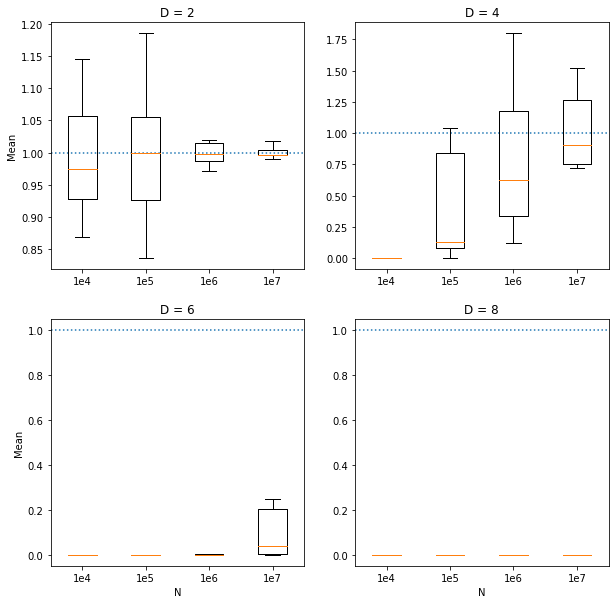

In [25]:
# result_mean vs samples for each dim

fig = plt.figure(figsize=(10,10))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_mean'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(2,2,i+1)
    ax.axhline(y=target_dict[f'{prefix}_d{ndims}'], linestyle=':')
    ax.set_title(f'D = {ndims}')
    if i > 1:
        ax.set_xlabel('N')
    if i % 2 == 0:
        ax.set_ylabel('Mean')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=False)

In [26]:
# fig.savefig('result/02_NaivePython/f1_uniform_mean_new.png')

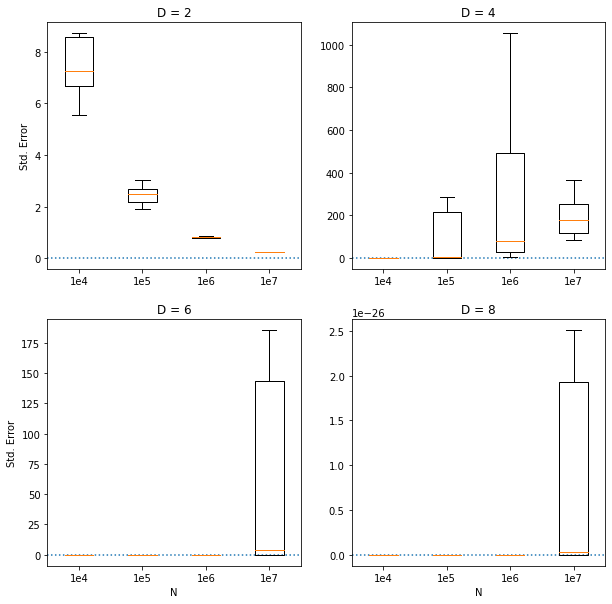

In [27]:
# sdev vs samples for each dim

fig = plt.figure(figsize=(10,10))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_sdev'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(2,2,i+1)
    ax.axhline(y=0, linestyle=':')
    ax.set_title(f'D = {ndims}')
    if i > 1:
        ax.set_xlabel('N')
    if i % 2 == 0:
        ax.set_ylabel('Std. Error')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=False)

In [28]:
# fig.savefig('result/02_NaivePython/f1_uniform_error_new.png')

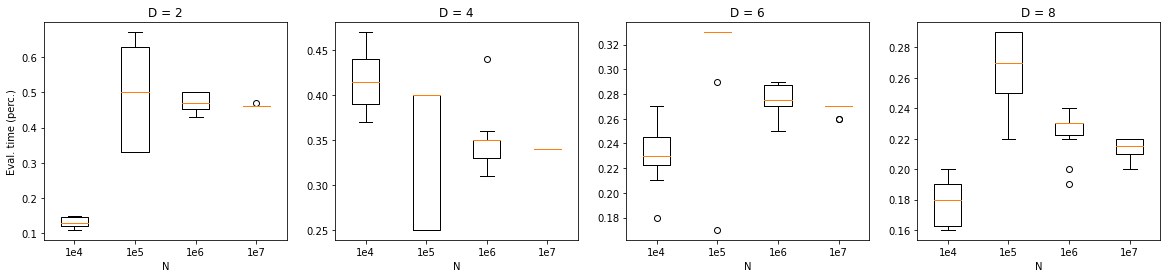

In [29]:
# eval_time_perc vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['eval_time_perc'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,len(ndims_lst),i+1)
    ax.set_title(f'D = {ndims}')
    ax.set_xlabel('N')
    if i == 0:
        ax.set_ylabel('Eval. time (perc.)')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None)

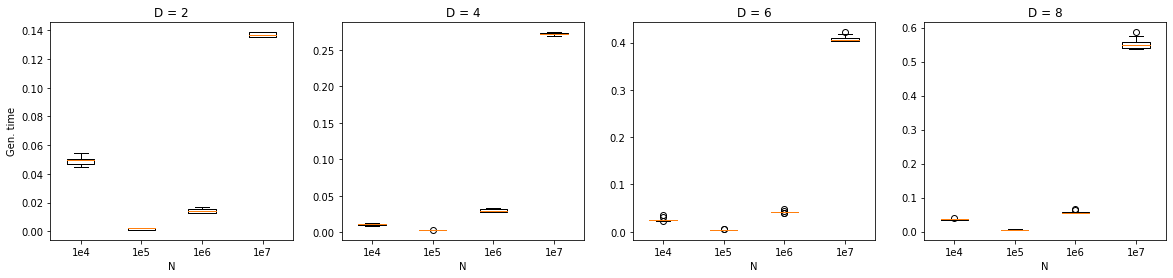

In [30]:
# result_gen_time vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_gen_time'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,len(ndims_lst),i+1)
    ax.set_title(f'D = {ndims}')
    ax.set_xlabel('N')
    if i == 0:
        ax.set_ylabel('Gen. time')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None)

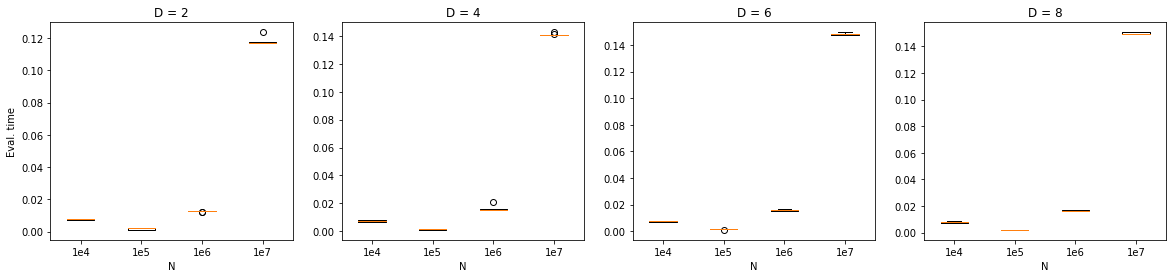

In [31]:
# result_eval_time vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].groupby('neval')['result_eval_time'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,len(ndims_lst),i+1)
    ax.set_title(f'D = {ndims}')
    ax.set_xlabel('N')
    if i == 0:
        ax.set_ylabel('Eval. time')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None)

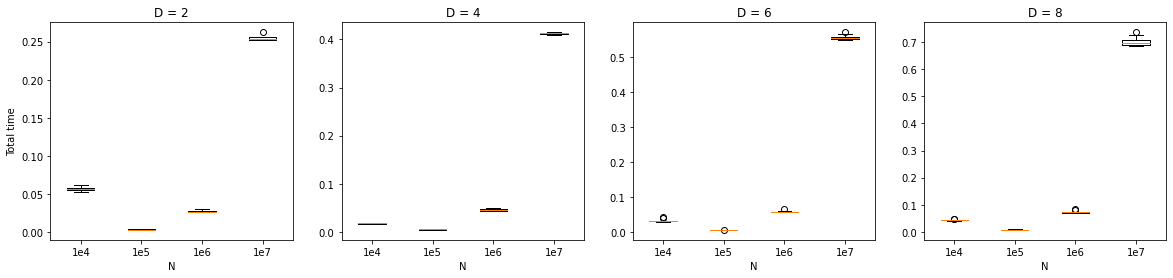

In [32]:
# total_time vs samples for each dim

fig = plt.figure(figsize=(20,4))

for i, ndims in enumerate(ndims_lst):
    plot_data = temp_df[temp_df.ndims == ndims].copy()
    plot_data['total_time'] = plot_data.result_eval_time + plot_data.result_gen_time
    plot_data = plot_data.groupby('neval')['total_time'].apply(lambda x: x.tolist())
    ax = fig.add_subplot(1,len(ndims_lst),i+1)
    ax.set_title(f'D = {ndims}')
    ax.set_xlabel('N')
    if i == 0:
        ax.set_ylabel('Total time')
    ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None)

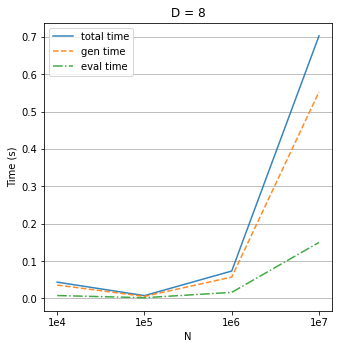

In [33]:
# total_time (D8) vs samples

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1])

plot_data = temp_df[temp_df.ndims == 8].copy()
plot_data['total_time'] = plot_data.result_eval_time + plot_data.result_gen_time
plot_data = plot_data.groupby('neval')['total_time'].apply(lambda x: x.tolist())
ax.set_title(f'D = {ndims}')
ax.set_xlabel('N')
ax.set_ylabel('Time (s)')
# ax.boxplot(plot_data, labels=['1e4', '1e5', '1e6', '1e7'], showfliers=None);
locs = ax.get_xticks()
ax.set_xticks(ax.get_xticks(), labels=['', '1e4', '1e5', '1e6', '1e7', ''])
ax.plot(ax.get_xticks()[1:-1], plot_data.apply(np.mean), linestyle='-', alpha=.9, label='total time')

plot_data = temp_df[temp_df.ndims == 8].copy()
plot_data['total_time'] = plot_data.result_eval_time + plot_data.result_gen_time
plot_data = plot_data.groupby('neval')['result_gen_time'].apply(lambda x: x.tolist())
ax.plot(ax.get_xticks()[1:-1], plot_data.apply(np.mean), linestyle='dashed', alpha=.9, label='gen time')

plot_data = temp_df[temp_df.ndims == 8].copy()
plot_data['total_time'] = plot_data.result_eval_time + plot_data.result_gen_time
plot_data = plot_data.groupby('neval')['result_eval_time'].apply(lambda x: x.tolist())
ax.plot(ax.get_xticks()[1:-1], plot_data.apply(np.mean), linestyle='dashdot', alpha=.9, label='eval time')

ax.legend()
ax.grid(axis='y')

In [34]:
# fig.savefig('result/02_NaiveTensorflowGraph/f1_uniform_time_new.png', bbox_inches='tight')

#### Time

In [35]:
time_df = temp_df[temp_df.neval == int(1e7)].groupby('ndims').agg([np.mean, np.std])

In [36]:
time_df

neval        result_mean                 result_sdev  \
             mean  std          mean           std          mean   
ndims                                                              
2      10000000.0  0.0  9.993910e-01  1.106713e-02  2.514577e-01   
4      10000000.0  0.0  1.013788e+00  3.060478e-01  2.009115e+02   
6      10000000.0  0.0  5.138880e-01  1.264563e+00  5.369397e+03   
8      10000000.0  0.0  1.492313e-09  4.718897e-09  7.041821e-14   

                    result_gen_time           result_eval_time            \
                std            mean       std             mean       std   
ndims                                                                      
2      3.880451e-03        0.137034  0.001426         0.117685  0.002155   
4      1.016086e+02        0.271873  0.001708         0.140923  0.000673   
6      1.642369e+04        0.408408  0.006817         0.148403  0.000787   
8      2.226819e-13        0.552922  0.016716         0.149999  0.000515   

      run_num          eval_time_perc           total_time            
         mean      std           mean       std       mean       std  
ndims                                                                 
2         5.5  3.02765          0.461  0.003162   0.254719  0.003090  
4         5.5  3.02765          0.340  0.000000   0.412796  0.001591  
6         5.5  3.02765          0.268  0.004216   0.556811  0.007315  
8         5.5  3.02765          0.214  0.006992   0.702921  0.016885

In [38]:
time_df[['result_gen_time', 'result_eval_time', 'total_time']]

result_gen_time           result_eval_time           total_time  \
                 mean       std             mean       std       mean   
ndims                                                                   
2            0.137034  0.001426         0.117685  0.002155   0.254719   
4            0.271873  0.001708         0.140923  0.000673   0.412796   
6            0.408408  0.006817         0.148403  0.000787   0.556811   
8            0.552922  0.016716         0.149999  0.000515   0.702921   

                 
            std  
ndims            
2      0.003090  
4      0.001591  
6      0.007315  
8      0.016885

In [131]:
# old sigma

# time_df[['result_gen_time', 'result_eval_time']]

result_gen_time           result_eval_time          
                 mean       std             mean       std
ndims                                                     
2            0.157479  0.010746         0.052858  0.001629
4            0.272072  0.000916         0.054953  0.000566
6            0.406213  0.000821         0.060837  0.000940
8            0.543047  0.004754         0.064029  0.000631

In [145]:
# old sigma

# def temp_foo(x4):
#     return x4[0] + ' ± ' + x4[1] + '\t& ' + x4[2] + ' ± ' + x4[3] + '\n'

# print(''.join([temp_foo(x.round(3).astype(str))
#        for x in time_df[['result_gen_time', 'result_eval_time']].values]))

0.157 ± 0.011	& 0.053 ± 0.002
0.272 ± 0.001	& 0.055 ± 0.001
0.406 ± 0.001	& 0.061 ± 0.001
0.543 ± 0.005	& 0.064 ± 0.001



In [167]:
t = time_df[['result_gen_time', 'result_eval_time']]
t['total_mean'] = time_df['result_gen_time']['mean'] + time_df['result_eval_time']['mean']
t['total_std'] = (time_df['result_gen_time']['std']**2 + time_df['result_eval_time']['std']**2)**.5

t

E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
E:\_MAGISTER_ACE\Наука\mc_integration\mcenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


result_gen_time           result_eval_time           total_mean  \
                 mean       std             mean       std              
ndims                                                                   
2            0.157479  0.010746         0.052858  0.001629   0.210337   
4            0.272072  0.000916         0.054953  0.000566   0.327025   
6            0.406213  0.000821         0.060837  0.000940   0.467050   
8            0.543047  0.004754         0.064029  0.000631   0.607076   

      total_std  
                 
ndims            
2      0.010869  
4      0.001077  
6      0.001248  
8      0.004796

In [168]:
def temp_print(xx):
    temp_foo = lambda x4: x4[0] + ' ± ' + x4[1] + '\n'
    print(''.join([temp_foo(x.round(3).astype(str))
           for x in xx.values]))
    
temp_print(t[['total_mean', 'total_std']])

0.21 ± 0.011
0.327 ± 0.001
0.467 ± 0.001
0.607 ± 0.005



In [75]:
# results from tf-eager

time_df[['result_gen_time', 'result_eval_time']]

result_gen_time           result_eval_time          
                 mean       std             mean       std
ndims                                                     
2            0.141920  0.010566         0.306081  0.006488
4            0.273069  0.006477         0.448800  0.010617
6            0.405315  0.002497         0.598299  0.005512
8            0.538459  0.001194         0.741417  0.005176

In [38]:
# results from numpy

time_df

neval      result_mean           result_sdev            \
             mean  std        mean       std        mean       std   
ndims                                                                
2      10000000.0  0.0    0.999689  0.001274    0.001755  0.000001   
4      10000000.0  0.0    1.002901  0.002062    0.010090  0.000050   
6      10000000.0  0.0    1.032724  0.094742    0.061146  0.006931   
8      10000000.0  0.0    1.037306  0.239534    0.291311  0.127133   

      result_gen_time           result_eval_time           run_num       \
                 mean       std             mean       std    mean  std   
ndims                                                                     
2            0.131648  0.000997         0.408574  0.001152     2.0  1.0   
4            0.263966  0.000567         0.519272  0.004704     2.0  1.0   
6            0.396606  0.001152         0.629982  0.004498     2.0  1.0   
8            0.529251  0.000576         0.725725  0.002303     2.0  1.0   

      eval_time_perc            
                mean       std  
ndims                           
2           0.760000  0.000000  
4           0.663333  0.005774  
6           0.613333  0.005774  
8           0.580000  0.000000

In [188]:
# results from pure python

time_df

# result_sdev reaches {0.001757, 0.009955, 0.054550, 0.348377} on N = 1e7 samples

neval      result_mean           result_sdev            \
             mean  std        mean       std        mean       std   
ndims                                                                
2      10000000.0  0.0    1.001198  0.001652    0.001757  0.000002   
4      10000000.0  0.0    0.991086  0.005009    0.009955  0.000051   
6      10000000.0  0.0    0.964469  0.010881    0.054550  0.000439   
8      10000000.0  0.0    0.994901  0.164678    0.348377  0.041304   

      result_gen_time           result_eval_time           run_num       \
                 mean       std             mean       std    mean  std   
ndims                                                                     
2            8.856975  0.294607        28.168985  0.115902     2.0  1.0   
4           11.174443  0.163424        31.525340  0.047521     2.0  1.0   
6           14.951008  0.395227        34.955499  0.124870     2.0  1.0   
8           17.394804  0.524048        38.047893  0.084381     2.0  1.0   

      eval_time_perc            
                mean       std  
ndims                           
2           0.756667  0.005774  
4           0.740000  0.000000  
6           0.696667  0.005774  
8           0.686667  0.005774